# Brain Tumor Auto-Segmentation for Magnetic Resonance Imaging (MRI)

## Outline
Use these links to jump to particular sections of this assignment!

- [1. Dataset](#1)
  - [1.1 What is an MRI?](#1-1)
  - [1.2 MRI Data Processing](#1-2)
  - [1.3 Exploring the Dataset](#1-3)
  - [1.4 Data Preprocessing](#1-4)
    - [1.4.1 Sub-volume Sampling](#1-4-1)
    - [1.4.2 Standardization](#1-4-2)
- [2. Model: 3D U-Net](#2)
- [3. Metrics](#3)
  - [3.1 Dice Coefficient](#3-1)
  - [3.2 Soft Dice Loss](#3-2)
- [4. Training](#4)
- [5. Evaluation](#5)
  - [5.1 Overall Performance](#5-1)
  - [5.2 Patch-level Predictions](#5-2)
  - [5.3 Running on Entire Scans](#5-3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

import json
import cv2
import h5py
import imageio
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
)
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

#from tensorflow.compat.v1.logging import INFO, set_verbosity

#set_verbosity(INFO)

K.set_image_data_format("channels_first")

<a name="1"></a>
# 1 Dataset
<a name="1-1"></a>
## 1.1 What is an MRI?

Magnetic resonance imaging (MRI) is an advanced imaging technique that is used to observe a variety of diseases and parts of the body. 

As we will see later, neural networks can analyze these images individually (as a radiologist would) or combine them into a single 3D volume to make predictions.

At a high level, MRI works by measuring the radio waves emitting by atoms subjected to a magnetic field. 

<img src="https://miro.medium.com/max/1740/1*yC1Bt3IOzNv8Pp7t1v7F1Q.png">

we'll build a multi-class segmentation model. We'll  identify 3 different abnormalities in each image: edemas, non-enhancing tumors, and enhancing tumors.

<a name="1-2"></a>

## 1.2 MRI Data Processing

We often encounter MR images in the [DICOM format](https://en.wikipedia.org/wiki/DICOM). 
- The DICOM format is the output format for most commercial MRI scanners. This type of data can be processed using the [pydicom](https://pydicom.github.io/pydicom/stable/getting_started.html) Python library. 

we will be using the data from the [Decathlon 10 Challenge](https://decathlon-10.grand-challenge.org). This data has been mostly pre-processed for the competition participants, however in real practice, MRI data needs to be significantly pre-preprocessed before we can use it to train our models.

<a name="1-3"></a>
## 1.3 Exploring the Dataset

Our dataset is stored in the [NifTI-1 format](https://nifti.nimh.nih.gov/nifti-1/) and we will be using the [NiBabel library](https://github.com/nipy/nibabel) to interact with the files. Each training sample is composed of two separate files:

The first file is an image file containing a 4D array of MR image in the shape of (240, 240, 155, 4). 
-  The first 3 dimensions are the X, Y, and Z values for each point in the 3D volume, which is commonly called a voxel. 
- The 4th dimension is the values for 4 different sequences
    - 0: FLAIR: "Fluid Attenuated Inversion Recovery" (FLAIR)
    - 1: T1w: "T1-weighted"
    - 2: t1gd: "T1-weighted with gadolinium contrast enhancement" (T1-Gd)
    - 3: T2w: "T2-weighted"

The second file in each training example is a label file containing a 3D array with the shape of (240, 240, 155).  
- The integer values in this array indicate the "label" for each voxel in the corresponding image files:
    - 0: background
    - 1: edema
    - 2: non-enhancing tumor
    - 3: enhancing tumor

We have access to a total of 484 training images which we will be splitting into a training (80%) and validation (20%) dataset.

Let's begin by looking at one single case and visualizing the data! You have access to 10 different cases via this notebook and we strongly encourage you to explore the data further on your own.

We'll use the [NiBabel library](https://nipy.org/nibabel/nibabel_images.html) to load the image and label for a case. The function is shown below to give you a sense of how it works. 

In [ ]:
# set home directory and data directory
HOME_DIR = "/content/drive/MyDrive/BraTS_Data"
DATA_DIR = HOME_DIR

In [ ]:
image_nifty_file = DATA_DIR + "/imagesTr/BRATS_003.nii.gz"
image = np.array(nib.load(image_nifty_file).get_fdata())

In [ ]:
image.shape

(240, 240, 155, 4)

In [ ]:
label_nifty_file = DATA_DIR + "/labelsTr/BRATS_003.nii.gz"
label = np.array(nib.load(label_nifty_file).get_fdata())

In [ ]:
label.shape

(240, 240, 155)

We'll now visualize an example.  

The colors correspond to each class.
- Red is edema
- Green is a non-enhancing tumor
- Blue is an enhancing tumor. 


In [ ]:
is_categorical=False
if not is_categorical:
    label_cat = to_categorical(label, num_classes=4).astype(np.uint8)
label_cat.shape

(240, 240, 155, 4)

In [ ]:
image_norm = cv2.normalize(image[:, :, :, 0], None, alpha=0, beta=255,
                      norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
image_norm.shape

(240, 240, 155)

In [ ]:
labeled_image = np.zeros_like(label_cat[:, :, :, 1:])

# remove tumor part from image
labeled_image[:, :, :, 0] = image_norm * (label_cat[:, :, :, 0])
labeled_image[:, :, :, 1] = image_norm * (label_cat[:, :, :, 0])
labeled_image[:, :, :, 2] = image_norm * (label_cat[:, :, :, 0])

# color labels
labeled_image += label_cat[:, :, :, 1:] * 255

labeled_image.shape

(240, 240, 155, 3)

In [ ]:
data_all = []
data_all.append(labeled_image)
np.array(data_all).shape

(1, 240, 240, 155, 3)

In [ ]:
# coronal plane
coronal = np.transpose(data_all, [1, 3, 2, 4, 0])
coronal = np.rot90(coronal, 1)
coronal.shape

(155, 240, 240, 3, 1)

In [ ]:
# transversal plane
transversal = np.transpose(data_all, [2, 1, 3, 4, 0])
transversal = np.rot90(transversal, 2)
transversal.shape

(240, 240, 155, 3, 1)

In [ ]:
# sagittal plane
sagittal = np.transpose(data_all, [2, 3, 1, 4, 0])
sagittal = np.rot90(sagittal, 1)
sagittal.shape

(155, 240, 240, 3, 1)

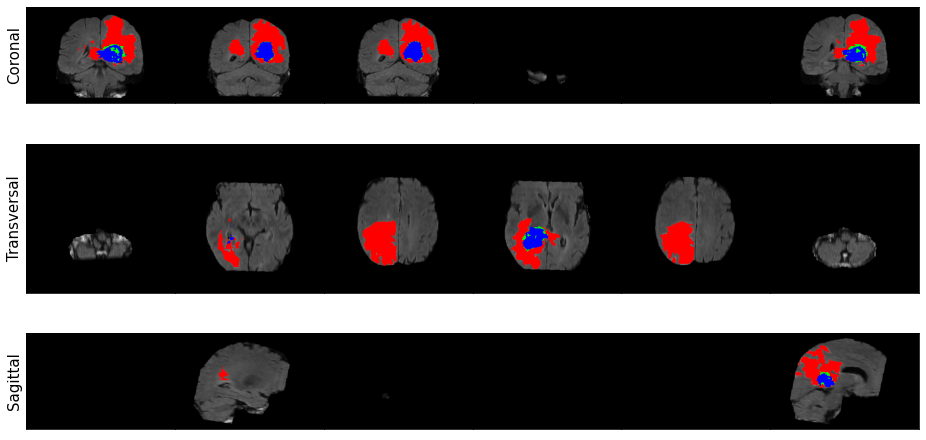

In [ ]:
fig, ax = plt.subplots(3, 6, figsize=[16, 9])

for i in range(6):
    n = np.random.randint(coronal.shape[2])
    ax[0][i].imshow(np.squeeze(coronal[:, :, n, :]))
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    if i == 0:
        ax[0][i].set_ylabel('Coronal', fontsize=15)

for i in range(6):
    n = np.random.randint(transversal.shape[2])
    ax[1][i].imshow(np.squeeze(transversal[:, :, n, :]))
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    if i == 0:
        ax[1][i].set_ylabel('Transversal', fontsize=15)

for i in range(6):
    n = np.random.randint(sagittal.shape[2])
    ax[2][i].imshow(np.squeeze(sagittal[:, :, n, :]))
    ax[2][i].set_xticks([])
    ax[2][i].set_yticks([])
    if i == 0:
        ax[2][i].set_ylabel('Sagittal', fontsize=15)

fig.subplots_adjust(wspace=0, hspace=0)


We've also written a utility function which generates a GIF that shows what it looks like to iterate over each axis.

<a name="1-4"></a>
## 1.4 Data Preprocessing using patches

While our dataset is provided to us post-registration and in the NIfTI format, we still have to do some minor pre-processing before feeding the data to our model. 

##### Generate sub-volumes

We are going to first generate "patches" of our data which you can think of as sub-volumes of the whole MR images. 
- The reason that we are generating patches is because a network that can process the entire volume at once will simply not fit inside our current environment's memory/GPU.
- Therefore we will be using this common technique to generate spatially consistent sub-volumes of our data, which can be fed into our network.
- Specifically, we will be generating randomly sampled sub-volumes of shape \[160, 160, 16\] from our images. 
- Furthermore, given that a large portion of the MRI volumes are just brain tissue or black background without any tumors, we want to make sure that we pick patches that at least include some amount of tumor data. 
- Therefore, we are only going to pick patches that have at most 95% non-tumor regions (so at least 5% tumor). 
- We do this by filtering the volumes based on the values present in the background labels.

##### Standardization (mean 0, stdev 1)

Lastly, given that the values in MR images cover a very wide range, we will standardize the values to have a mean of zero and standard deviation of 1. 
- This is a common technique in deep image processing since standardization makes it much easier for the network to learn.

Let's walk through these steps in the following exercises.

<a name="1-4-1"></a>
### 1.4.1 Sub-volume Sampling
Fill in the function below takes in:
- a 4D image (shape: \[240, 240, 155, 4\])
- its 3D label (shape: \[240, 240, 155\]) arrays, 

The function returns:
 - A randomly generated sub-volume of size \[160, 160, 16\]
 - Its corresponding label in a 1-hot format which has the shape \[3, 160, 160, 16\]



In [ ]:
def get_sub_volume(image, label, 
                   orig_x = 240, orig_y = 240, orig_z = 155, 
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.95):
    """
    returns:
        X (np.array): saiginalmple of or image of dimension 
            (num_channels, output_x, output_y, output_z)
        y (np.array): labels which correspond to X, of dimension 
            (num_classes, output_x, output_y, output_z)
    """
    # Initialize features and labels with `None`
    X = None
    y = None

    tries = 0    
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        # hint: make sure to leave enough room for the output dimensions!
        start_x = np.random.randint(0, orig_x - output_x+1)
        start_y = np.random.randint(0, orig_y - output_y+1)
        start_z = np.random.randint(0, orig_z - output_z+1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
        y = keras.utils.to_categorical(y, num_classes=num_classes)

        # compute the background ratio
        bgrd_ratio = np.sum(y[:, :, :, 0])/(output_x * output_y * output_z)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            
            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
            X = np.moveaxis(X, 3, 0)

            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y, 3, 0)

            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
            y = y[1:, :, :, :]
    
            return X, y

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")

### Test Case:

In [ ]:
np.random.seed(3)

image = np.zeros((4, 4, 3, 1))
label = np.zeros((4, 4, 3))
for i in range(4):
    for j in range(4):
        for k in range(3):
            image[i, j, k, 0] = i*j*k
            label[i, j, k] = k

print("image:")
for k in range(3):
    print(f"z = {k}")
    print(image[:, :, k, 0])
print("\n")
print("label:")
for k in range(3):
    print(f"z = {k}")
    print(label[:, :, k])

image:
z = 0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
z = 1
[[0. 0. 0. 0.]
 [0. 1. 2. 3.]
 [0. 2. 4. 6.]
 [0. 3. 6. 9.]]
z = 2
[[ 0.  0.  0.  0.]
 [ 0.  2.  4.  6.]
 [ 0.  4.  8. 12.]
 [ 0.  6. 12. 18.]]


label:
z = 0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
z = 1
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
z = 2
[[2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]]


#### Test: Extracting (2, 2, 2) sub-volume

In [ ]:
sample_image, sample_label = get_sub_volume(image, 
                                            label,
                                            orig_x=4, 
                                            orig_y=4, 
                                            orig_z=3,
                                            output_x=2, 
                                            output_y=2, 
                                            output_z=2,
                                            num_classes = 3)

print("Sampled Image:")
for k in range(2):
    print("z = " + str(k))
    print(sample_image[0, :, :, k])

Sampled Image:
z = 0
[[0. 2.]
 [0. 3.]]
z = 1
[[0. 4.]
 [0. 6.]]


#### Expected output:

```Python
Sampled Image:
z = 0
[[0. 2.]
 [0. 3.]]
z = 1
[[0. 4.]
 [0. 6.]]
```

In [ ]:
print("Sampled Label:")
for c in range(2):
    print("class = " + str(c))
    for k in range(2):
        print("z = " + str(k))
        print(sample_label[c, :, :, k])

Sampled Label:
class = 0
z = 0
[[1. 1.]
 [1. 1.]]
z = 1
[[0. 0.]
 [0. 0.]]
class = 1
z = 0
[[0. 0.]
 [0. 0.]]
z = 1
[[1. 1.]
 [1. 1.]]


#### Expected output:

```Python
Sampled Label:
class = 0
z = 0
[[1. 1.]
 [1. 1.]]
z = 1
[[0. 0.]
 [0. 0.]]
class = 1
z = 0
[[0. 0.]
 [0. 0.]]
z = 1
[[1. 1.]
 [1. 1.]]
```

You can run the following cell to look at a candidate patch and ensure that the function works correctly. We'll look at the enhancing tumor part of the label.

In [ ]:
# set home directory and data directory
HOME_DIR = "./BraTS-Data/"
DATA_DIR = HOME_DIR

def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    return image, label

In [ ]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_001.nii.gz", DATA_DIR + "labelsTr/BRATS_001.nii.gz")
X, y = get_sub_volume(image, label)

In [ ]:
X.shape

(4, 160, 160, 16)

In [ ]:
y.shape

(3, 160, 160, 16)

In [ ]:
def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 5], squeeze=False)

    ax[0][0].imshow(X[:, :, 0], cmap='Greys_r')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    ax[0][1].imshow(y[:, :, 0], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)

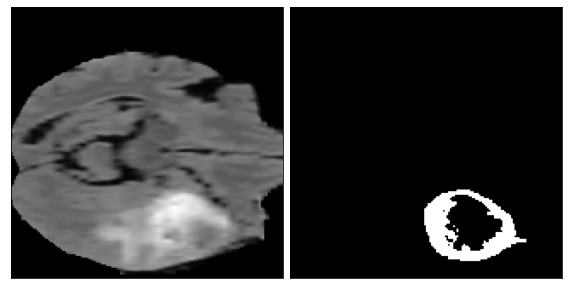

In [ ]:
# enhancing tumor is channel 2 in the class label
# you can change indexer for y to look at different classes
visualize_patch(X[0, :, :, :], y[2])

<a name="1-4-2"></a>
### 1.4.2 Standardization

Next, fill in the following function that given a patch (sub-volume), standardizes the values across each channel and each Z plane to have a mean of zero and standard deviation of 1. 

In [ ]:
def standardize(image):
    """
    Returns:
        standardized_image (np.array): standardized version of input image
    """
        
    # initialize to array of zeros, with same shape as the image
    standardized_image = np.zeros(image.shape)

    # iterate over channels
    for c in range(image.shape[0]):
        # iterate over the `z` dimension
        for z in range(image.shape[3]):
            # get a slice of the image 
            # at channel c and z-th dimension `z`
            image_slice = image[c,:,:,z]

            # subtract the mean
            centered = image_slice - np.mean(image_slice)

            # divide by the standard deviation
            if np.std(centered) != 0:
                centered_scaled = centered / np.std(centered)

            # update  the slice of standardized image
            # with the scaled centered and scaled image
            standardized_image[c, :, :, z] = centered_scaled


    return standardized_image

And to sanity check, let's look at the output of our function:

In [ ]:
X_norm = standardize(X)
print("standard deviation for a slice should be 1.0")
print(f"stddv for X_norm[0, :, :, 0]: {X_norm[0,:,:,0].std():.2f}")

standard deviation for a slice should be 1.0
stddv for X_norm[0, :, :, 0]: 1.00


Let's visualize our patch again just to make sure (it won't look different since the `imshow` function we use to visualize automatically normalizes the pixels when displaying in black and white).

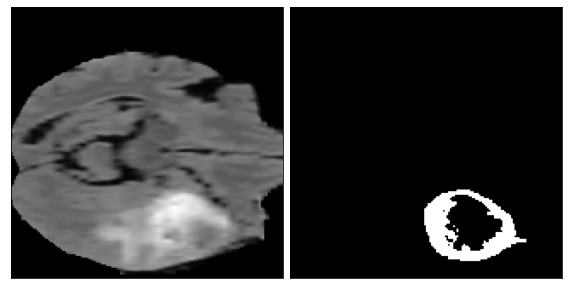

In [ ]:
visualize_patch(X_norm[0, :, :, :], y[2])

<a name="2"></a>
# 2 Model: 3D U-Net
Now let's build our model. We will be building a [3D U-net](https://arxiv.org/abs/1606.06650). 
- This architecture will take advantage of the volumetric shape of MR images and is one of the best performing models for this task. 
- Feel free to familiarize yourself with the architecture by reading [this paper](https://arxiv.org/abs/1606.06650).

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="50%">

<a name="3"></a>
# 3 Metrics

<a name="3-1"></a>
## 3.1 Dice Similarity Coefficient

Aside from the architecture, one of the most important elements of any deep learning method is the choice of our loss function. 

A natural choice that you may be familiar with is the cross-entropy loss function. 
- However, this loss function is not ideal for segmentation tasks due to heavy class imbalance (there are typically not many positive regions). 

A much more common loss for segmentation tasks is the Dice similarity coefficient, which is a measure of how well two contours overlap. 
- The Dice index ranges from 0 (complete mismatch) 
- To 1 (perfect match).

In general, for two sets $A$ and $B$, the Dice similarity coefficient is defined as: 
$$\text{DSC}(A, B) = \frac{2 \times |A \cap B|}{|A| + |B|}.$$

Here we can interpret $A$ and $B$ as sets of voxels, $A$ being the predicted tumor region and $B$ being the ground truth. 

Our model will map each voxel to 0 or 1
- 0 means it is a background voxel
- 1 means it is part of the segmented region.

In the dice coefficient, the variables in the formula are:
- $x$ : the input image
- $f(x)$ : the model output (prediction)
- $y$ : the label (actual ground truth)

The dice coefficient "DSC" is:

$$\text{DSC}(f, x, y) = \frac{2 \times \sum_{i, j} f(x)_{ij} \times y_{ij} + \epsilon}{\sum_{i,j} f(x)_{ij} + \sum_{i, j} y_{ij} + \epsilon}$$

- $\epsilon$ is a small number that is added to avoid division by zero

<img src="https://www.researchgate.net/publication/328671987/figure/fig4/AS:688210103529478@1541093483784/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from.ppm" width="30%">

[Image Source](https://www.researchgate.net/figure/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from_fig4_328671987)

Implement the dice coefficient for a single output class below.

- Please use the [Keras.sum(x,axis=)](https://www.tensorflow.org/api_docs/python/tf/keras/backend/sum) function to compute the numerator and denominator of the dice coefficient.

In [ ]:
def single_class_dice_coefficient(y_true, y_pred, axis=(0, 1, 2), 
                                  epsilon=0.00001):
    """
    Compute dice coefficient for single class.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for single class.
                                    shape: (x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for single class.
                                    shape: (x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum function.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = (dice_numerator) / (dice_denominator)

    return dice_coefficient

In [ ]:
pred = np.expand_dims(np.eye(2), -1)
label = np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), -1)

print("Test Case #1")
print("pred:")
print(pred[:, :, 0])
print("label:")
print(label[:, :, 0])

# choosing a large epsilon to help check for implementation errors
dc = single_class_dice_coefficient(pred, label,epsilon=1)
print(f"dice coefficient: {dc.numpy():.4f}")

print("\n")


Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
dice coefficient: 0.6000




##### Expected output

If you get a different result, please check that you implemented the equation completely.
```Python
Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
dice coefficient: 0.6000


Test Case #2
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 1.]]
dice_coefficient: 0.8333
```

### Dice Coefficient for Multiple classes
Now that we have the single class case, we can think about how to approach the multi class context. 
- Remember that for this task, we want segmentations for each of the 3 classes of abnormality (edema, enhancing tumor, non-enhancing tumor). 
- This will give us 3 different dice coefficients (one for each abnormality class). 
- To combine these, we can just take the average. We can write that the overall dice coefficient is: 

$$DC(f, x, y) = \frac{1}{3} \left ( DC_{1}(f, x, y) + DC_{2}(f, x, y) + DC_{3}(f, x, y) \right )$$

- $DC_{1}$, $DC_{2}$ and $DC_{3}$ are edema, enhancing tumor, and non-enhancing tumor dice coefficients.

For any number of classes, the equation becomes:  
$$DC(f, x, y) = \frac{1}{N} \sum_{c=1}^{C} \left ( DC_{c}(f, x, y) \right )$$

In this case, with three categories, $C = 3$

Implement the mean dice coefficient below. This should not be very different from your singe-class implementation.

In [ ]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean((dice_numerator)/(dice_denominator))
 
    return dice_coefficient

In [ ]:
# TEST CASES
pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)

print("Test Case #1")
print("pred:")
print(pred[0, :, :, 0])
print("label:")
print(label[0, :, :, 0])

dc = dice_coefficient(label, pred, epsilon=1)
print(f"dice coefficient: {dc.numpy():.4f}")

print("\n")

print("Test Case #2")
pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), 0), -1)


print("pred:")
print(pred[0, :, :, 0])
print("label:")
print(label[0, :, :, 0])

dc = dice_coefficient(pred, label,epsilon=1)
print(f"dice coefficient: {dc.numpy():.4f}")
print("\n")


print("Test Case #3")
pred = np.zeros((2, 2, 2, 1))
pred[0, :, :, :] = np.expand_dims(np.eye(2), -1)
pred[1, :, :, :] = np.expand_dims(np.eye(2), -1)

label = np.zeros((2, 2, 2, 1))
label[0, :, :, :] = np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), -1)
label[1, :, :, :] = np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), -1)

print("pred:")
print("class = 0")
print(pred[0, :, :, 0])
print("class = 1")
print(pred[1, :, :, 0])
print("label:")
print("class = 0")
print(label[0, :, :, 0])
print("class = 1")
print(label[1, :, :, 0])

dc = dice_coefficient(pred, label,epsilon=1)
print(f"dice coefficient: {dc.numpy():.4f}")

Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
dice coefficient: 0.6000


Test Case #2
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 1.]]
dice coefficient: 0.8333


Test Case #3
pred:
class = 0
[[1. 0.]
 [0. 1.]]
class = 1
[[1. 0.]
 [0. 1.]]
label:
class = 0
[[1. 1.]
 [0. 0.]]
class = 1
[[1. 1.]
 [0. 1.]]
dice coefficient: 0.7167


#### Expected output:

```Python
Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
dice coefficient: 0.6000


Test Case #2
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 1.]]
dice coefficient: 0.8333


Test Case #3
pred:
class = 0
[[1. 0.]
 [0. 1.]]
class = 1
[[1. 0.]
 [0. 1.]]
label:
class = 0
[[1. 1.]
 [0. 0.]]
class = 1
[[1. 1.]
 [0. 1.]]
dice coefficient: 0.7167
```

<a name="3-2"></a>
## 3.2 Soft Dice Loss

While the Dice Coefficient makes intuitive sense, it is not the best for training. 
- This is because it takes in discrete values (zeros and ones). 
- The model outputs *probabilities* that each pixel is, say, a tumor or not, and we want to be able to backpropagate through those outputs. 

Therefore, we need an analogue of the Dice loss which takes real valued input. This is where the **Soft Dice loss** comes in. The formula is: 

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{2\times\sum_{i, j} p_{ij}q_{ij} + \epsilon}{\left(\sum_{i, j} p_{ij}^2 \right) + \left(\sum_{i, j} q_{ij}^2 \right) + \epsilon}$$

- $p$ is our predictions
- $q$ is the ground truth 
- In practice each $q_i$ will either be 0 or 1. 
- $\epsilon$ is a small number that is added to avoid division by zero

The soft Dice loss ranges between 
- 0: perfectly matching the ground truth distribution $q$
- 1: complete mismatch with the ground truth.

You can also check that if $p_i$ and $q_i$ are each 0 or 1, then the soft Dice loss is just one minus the dice coefficient.


### Multi-Class Soft Dice Loss

We've explained the single class case for simplicity, but the multi-class generalization is exactly the same as that of the dice coefficient. 
- Since you've already implemented the multi-class dice coefficient, we'll have you jump directly to the multi-class soft dice loss.

For any number of categories of diseases, the expression becomes:

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{1}{N} \sum_{c=1}^{C} \frac{2\times\sum_{i, j} p_{cij}q_{cij} + \epsilon}{\left(\sum_{i, j} p_{cij}^2 \right) + \left(\sum_{i, j} q_{cij}^2 \right) + \epsilon}$$


In [ ]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))

    return dice_loss

#### Test Case 1

In [ ]:
# TEST CASES
pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)

print("Test Case #1")
print("pred:")
print(pred[0, :, :, 0])
print("label:")
print(label[0, :, :, 0])

dc = soft_dice_loss(pred, label, epsilon=1)
print(f"soft dice loss:{dc.numpy():.4f}")

Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
soft dice loss:0.4000


#### Expected output:

```Python
Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
soft dice loss:0.4000
```

<a name="4"></a>
# 4 Create and Train the model

Once you've finished implementing the soft dice loss, we can create the model! 

In [ ]:
def create_convolution_block(input_layer, n_filters, batch_normalization=False,
                             kernel=(3, 3, 3), activation=None,
                             padding='same', strides=(1, 1, 1),
                             instance_normalization=False):
    """
    :param strides:
    :param input_layer:
    :param n_filters:
    :param batch_normalization:
    :param kernel:
    :param activation: Keras activation layer to use. (default is 'relu')
    :param padding:
    :return:
    """
    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides)(
        input_layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)

In [ ]:
def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2, 2),
                       strides=(2, 2, 2),
                       deconvolution=False):
    if deconvolution:
        return Conv3DTranspose(filters=n_filters, kernel_size=kernel_size,
                               strides=strides)
    else:
        return UpSampling3D(size=pool_size)

In [ ]:
def unet_model_3d(loss_function, input_shape=(4, 160, 160, 16),
                  pool_size=(2, 2, 2), n_labels=3, # pool size can be  ( 4 , 4 4) but will takedf more meory
                  initial_learning_rate=0.00001,
                  deconvolution=False, depth=4, n_base_filters=32,   # changed from 64 filters to 32 
                  include_label_wise_dice_coefficients=False, metrics=[],
                  batch_normalization=False, activation_name="sigmoid"):
    """

    
    :param n_base_filters: The number of filters that the first layer in the convolution network will have. Following
    layers will contain a multiple of this number. Lowering this number will likely reduce the amount of memory required
    to train the model.
    
    :param depth: indicates the depth of the U-shape for the model. The greater the depth, the more max pooling
    layers will be added to the model. Lowering the depth may reduce the amount of memory required for training.
    
    :param input_shape: Shape of the input data (n_chanels, x_size, y_size, z_size). The x, y, and z sizes must be
    divisible by the pool size to the power of the depth of the UNet, that is pool_size^depth.
    
    :param pool_size: Pool size for the max pooling operations.
    
    :param n_labels: Number of binary labels that the model is learning.
    
    :param initial_learning_rate: Initial learning rate for the model. This will be decayed during training.
    :param deconvolution: If set to True, will use transpose convolution(deconvolution) instead of up-sampling. This
    increases the amount memory required during training.
    
    :return: Untrained 3D UNet Model
    """
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()

    # add levels with max pooling
    for layer_depth in range(depth):
        layer1 = create_convolution_block(input_layer=current_layer,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth),
                                          batch_normalization=batch_normalization)
        layer2 = create_convolution_block(input_layer=layer1,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth) * 2,
                                          batch_normalization=batch_normalization)
        if layer_depth < depth - 1:
            current_layer = MaxPooling3D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])

    # add levels with up-convolution or up-sampling
    for layer_depth in range(depth - 2, -1, -1):
        
        #print(K.int_shape(current_layer)[1])
        up_convolution = get_up_convolution(pool_size=pool_size,
                                            deconvolution=deconvolution,
                                            n_filters=K.int_shape(current_layer)[1])(current_layer)
        
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=1)
        
        #print(K.int_shape(levels[layer_depth][1])[1])
        current_layer = create_convolution_block(n_filters= K.int_shape(levels[layer_depth][1])[1],
                                                 input_layer=concat, 
                                                 batch_normalization=batch_normalization)
        
        current_layer = create_convolution_block(n_filters= K.int_shape(levels[layer_depth][1])[1],
                                                 input_layer=current_layer,
                                                 batch_normalization=batch_normalization)

    final_convolution = Conv3D(n_labels, (1, 1, 1))(current_layer)
    act = Activation(activation_name)(final_convolution)
    model = Model(inputs=inputs, outputs=act)

    if not isinstance(metrics, list):
        metrics = [metrics]

    model.compile(optimizer=Adam(lr=initial_learning_rate), loss=loss_function,
                  metrics=metrics)
    return model

In [ ]:
model = unet_model_3d(loss_function=soft_dice_loss, metrics=[dice_coefficient])

<a name="4-1"></a>
## 4.1 Training on a Large Dataset
store the paches data in[`h5py`](http://docs.h5py.org/en/stable/) format. 
- We also wrote a custom Keras [`Sequence`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence) class which can be used as a `Generator` for the keras model to train on large datasets. 

To get a flavor of the training on the larger dataset, you can run the following cell to train the model on a small subset of the dataset (85 patches). You should see the loss going down and the dice coefficient going up. 



In [ ]:
base_dir = HOME_DIR + "processed/"

with open(base_dir + "config.json") as json_file:
    config = json.load(json_file)

config

{'train': ['BRATS_009.nii.gz_4_x16_y62_z63.h5',
  'BRATS_009.nii.gz_5_x72_y76_z90.h5',
  'BRATS_009.nii.gz_6_x46_y13_z68.h5',
  'BRATS_009.nii.gz_7_x47_y45_z63.h5',
  'BRATS_009.nii.gz_8_x59_y12_z74.h5',
  'BRATS_009.nii.gz_9_x15_y12_z97.h5',
  'BRATS_009.nii.gz_10_x78_y33_z93.h5',
  'BRATS_009.nii.gz_11_x21_y0_z68.h5',
  'BRATS_009.nii.gz_12_x42_y77_z72.h5',
  'BRATS_009.nii.gz_13_x8_y78_z86.h5',
  'BRATS_009.nii.gz_14_x60_y30_z71.h5',
  'BRATS_009.nii.gz_15_x66_y24_z97.h5',
  'BRATS_009.nii.gz_16_x78_y67_z82.h5',
  'BRATS_009.nii.gz_17_x78_y79_z80.h5',
  'BRATS_009.nii.gz_18_x30_y51_z79.h5',
  'BRATS_009.nii.gz_19_x67_y37_z58.h5',
  'BRATS_009.nii.gz_20_x73_y43_z83.h5'],
 'valid': ['BRATS_119.nii.gz_1_x14_y41_z78.h5',
  'BRATS_119.nii.gz_2_x38_y26_z74.h5',
  'BRATS_119.nii.gz_3_x48_y40_z72.h5',
  'BRATS_119.nii.gz_4_x45_y14_z89.h5',
  'BRATS_119.nii.gz_5_x5_y32_z80.h5',
  'BRATS_119.nii.gz_6_x55_y65_z77.h5',
  'BRATS_119.nii.gz_7_x43_y52_z77.h5',
  'BRATS_119.nii.gz_8_x57_y53_z89.h5'

In [ ]:
len(config["train"])

17

In [ ]:
# Initialization
num_channels = 4
num_classes = 3
dim = (160,160,16)
X_train = np.zeros((len(config["train"]), num_channels, *dim),
             dtype=np.float64)
y_train = np.zeros((len(config["train"]), num_classes, *dim),
             dtype=np.float64)

In [ ]:
# Generate data
base_dir = HOME_DIR + "processed/"
directory_train = base_dir + "train/"
print(directory_train)

./BraTS-Data/processed/train/


In [ ]:
for i,ID in enumerate(config["train"]):
    # Store sample
    with h5py.File(directory_train + ID, 'r') as f:
        X_train[i] = np.array(f.get("x"))
        # remove the background class
        y_train[i] = np.moveaxis(np.array(f.get("y")), 3, 0)[1:]

In [ ]:
X_train.shape

(17, 4, 160, 160, 16)

In [ ]:
y_train.shape

(17, 3, 160, 160, 16)

In [ ]:
len(config["valid"])

20

In [ ]:
# Initialization
num_channels = 4
num_classes = 3
dim = (160,160,16)
X_valid = np.zeros((len(config["valid"]), num_channels, *dim),
             dtype=np.float64)
y_valid = np.zeros((len(config["valid"]), num_classes, *dim),
             dtype=np.float64)

In [ ]:
# Generate data
base_dir = HOME_DIR + "processed/"
directory_valid = base_dir + "valid/"
print(directory_valid)

./BraTS-Data/processed/valid/


In [ ]:
for i,ID in enumerate(config["valid"]):
    # Store sample
    with h5py.File(directory_valid + ID, 'r') as f:
        X_valid[i] = np.array(f.get("x"))
        # remove the background class
        y_valid[i] = np.moveaxis(np.array(f.get("y")), 3, 0)[1:]

In [ ]:
X_valid.shape

(20, 4, 160, 160, 16)

In [ ]:
y_valid.shape

(20, 3, 160, 160, 16)

In [ ]:
n_epochs=2
model.fit(X_train,y_train,
        epochs=n_epochs,
        #use_multiprocessing=True,
        validation_data= (X_valid,y_valid),
        verbose=1)


Train on 17 samples, validate on 20 samples
Epoch 1/2
17/17 [==============================] - 15s 894ms/sample


ResourceExhaustedError:  OOM when allocating tensor with shape[17,64,160,160,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/conv3d_1/Conv3D (defined at <ipython-input-60-bc017a32f0eb>:6) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_6566]

Function call stack:
distributed_function


```python
n_epochs=2
model.fit(X_train,y_train,
        epochs=n_epochs,
        #use_multiprocessing=True,
        validation_data= (X_valid,y_valid),
        verbose=1)
```

In [ ]:
class VolumeDataGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                sample_list,
                 base_dir,
                 batch_size=1,
                 shuffle=True,
                 dim=(160, 160, 16),
                 num_channels=4,
                 num_classes=3,
                 verbose=1):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.base_dir = base_dir
        self.dim = dim
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.verbose = verbose
        self.sample_list = sample_list
        self.on_epoch_end()
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.sample_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.sample_list) / self.batch_size))
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size, self.num_channels, *self.dim),
                     dtype=np.float64)
        y = np.zeros((self.batch_size, self.num_classes, *self.dim),
                     dtype=np.float64)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.verbose == 1:
                print("Training on: %s" % self.base_dir + ID)
            with h5py.File(self.base_dir + ID, 'r') as f:
                X[i] = np.array(f.get("x"))
                # remove the background class
                y[i] = np.moveaxis(np.array(f.get("y")), 3, 0)[1:]
        return X, y
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[
                  index * self.batch_size: (index + 1) * self.batch_size]
        # Find list of IDs
        sample_list_temp = [self.sample_list[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(sample_list_temp)
        return X, y
 

In [ ]:
# Get generators for training and validation sets
train_generator = VolumeDataGenerator(config["train"], base_dir + "train/", batch_size=1, dim=(160, 160, 16), verbose=0)
valid_generator = VolumeDataGenerator(config["valid"], base_dir + "valid/", batch_size=1, dim=(160, 160, 16), verbose=0)
train_generator

In [ ]:
#steps_per_epoch = 10
n_epochs=10
#validation_steps = 10

model.fit(train_generator,
        #steps_per_epoch=steps_per_epoch,
        epochs=n_epochs,
        #use_multiprocessing=True,
        validation_data=valid_generator,
        #validation_steps=validation_steps,
         verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 17 steps, validate for 20 steps
Epoch 1/10
17/17 [==============================] - 72s 4s/step - loss: 0.7925 - dice_coefficient: 0.1664 - val_loss: 0.8192 - val_dice_coefficient: 0.1596
Epoch 2/10
17/17 [==============================] - 54s 3s/step - loss: 0.6433 - dice_coefficient: 0.2861 - val_loss: 0.8953 - val_dice_coefficient: 0.0857
Epoch 3/10
17/17 [==============================] - 53s 3s/step - loss: 0.4399 - dice_coefficient: 0.4536 - val_loss: 0.8296 - val_dice_coefficient: 0.1463
Epoch 4/10
17/17 [==============================] - 51s 3s/step - loss: 0.3676 - dice_coefficient: 0.5319 - val_loss: 0.7775 - val_dice_coefficient: 0.1965
Epoch 5/10
17/17 [==============================] - 52s 3s/step - loss: 0.3169 - dice_coefficient: 0.5903 - val_loss: 0.7213 - val_dice_coefficient: 0.2527
Epoch 6/10
17/17 [==============================] - 52s 3s/step - loss: 0.2879 - dice_coefficient: 0.6268 - val_loss: 0.6678 - v

In [ ]:
# run this cell if you to save the weights of your trained model in cell above
model.save_weights(HOME_DIR + 'my_model_pretrained.hdf5')

<a name="4-2"></a>
## 4.2 Loading a Pre-Trained Model
As in assignment 1, instead of having the model train for longer, we'll give you access to a pretrained version. We'll use this to extract predictions and measure performance.

In [ ]:
HOME_DIR = "./BraTS-Data/"
model.load_weights(HOME_DIR + "my_model_pretrained.hdf5")

<a name="5"></a>
# 5 Evaluation

Now that we have a trained model, we'll learn to extract its predictions and evaluate its performance on scans from our validation set.

<a name="5-1"></a>
## 5.1 Overall Performance

First let's measure the overall performance on the validation set. 

#### Using the validation set for testing
- Note: since we didn't do cross validation tuning on the final model, it's okay to use the validation set.
- For real life implementations, however, you would want to do cross validation as usual to choose hyperparamters and then use a hold out test set to assess performance


In [ ]:
val_loss, val_dice = model.evaluate(valid_generator)

print(f"validation soft dice loss: {val_loss:.4f}")
print(f"validation dice coefficient: {val_dice:.4f}")

  ...
    to  
  ['...']
20/20 [==============================] - 11s 541ms/step - loss: 0.6461 - dice_coefficient: 0.3440
validation soft dice loss: 0.6461
validation dice coefficient: 0.3440


<a name="5-2"></a>
## 5.2 Patch-level predictions

When applying the model, we'll want to look at segmentations for individual scans (entire scans, not just the sub-volumes)
- This will be a bit complicated because of our sub-volume approach. 
- First let's keep things simple and extract model predictions for sub-volumes.
- We can use the sub-volume which we extracted at the beginning of the assignment.

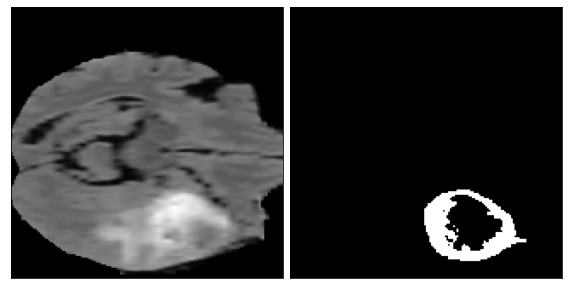

In [ ]:
visualize_patch(X_norm[0, :, :, :], y[2])

In [ ]:
X_norm_with_batch_dimension = np.expand_dims(X_norm, axis=0)
patch_pred = model.predict(X_norm_with_batch_dimension)

#### Convert prediction from probability into a category
Currently, each element of `patch_pred` is a number between 0.0 and 1.0.
- Each number is the model's confidence that a voxel is part of a given class. 
- You will convert these to discrete 0 and 1 integers by using a threshold. 
- We'll use a threshold of 0.5. 
- In real applications, you would tune this to achieve your required level  of sensitivity or specificity.

In [ ]:
# set threshold.
threshold = 0.5

# use threshold to get hard predictions
patch_pred[patch_pred > threshold] = 1.0
patch_pred[patch_pred <= threshold] = 0.0

Now let's visualize the original patch and ground truth alongside our thresholded predictions.

Patch and ground truth


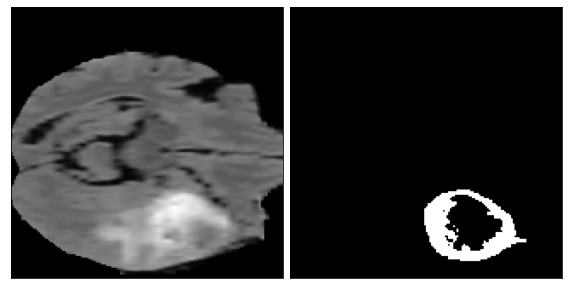

Patch and prediction


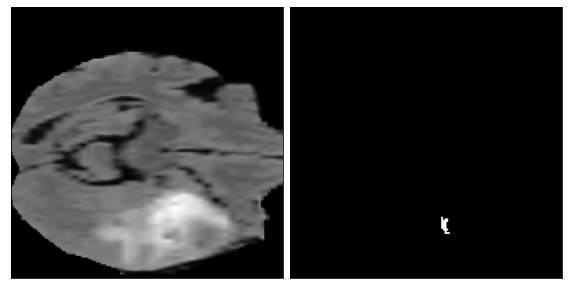

In [ ]:
print("Patch and ground truth")
visualize_patch(X_norm[0, :, :, :], y[2])
plt.show()
print("Patch and prediction")
visualize_patch(X_norm[0, :, :, :], patch_pred[0, 2, :, :, :])
plt.show()

#### Sensitivity and Specificity

The model is covering some of the relevant areas, but it's definitely not perfect. 
- To quantify its performance, we can use per-pixel sensitivity and specificity. 

Recall that in terms of the true positives, true negatives, false positives, and false negatives, 

$$\text{sensitivity} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

$$\text{specificity} = \frac{\text{true negatives}}{\text{true negatives} + \text{false positives}}$$

Below let's write a function to compute the sensitivity and specificity per output class.

In [ ]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def compute_class_sens_spec(pred, label, class_num):
    """
    Compute sensitivity and specificity for a particular example
    for a given class.

    Args:
        pred (np.array): binary arrary of predictions, shape is
                         (num classes, height, width, depth).
        label (np.array): binary array of labels, shape is
                          (num classes, height, width, depth).
        class_num (int): number between 0 - (num_classes -1) which says
                         which prediction class to compute statistics
                         for.

    Returns:
        sensitivity (float): precision for given class_num.
        specificity (float): recall for given class_num
    """

    # extract sub-array for specified class
    class_pred = pred[class_num]
    class_label = label[class_num]

    # compute:
    
    # true positives
    tp = np.sum((class_pred == 1) & (class_label == 1))

    # true negatives
    tn = np.sum((class_pred == 0) & (class_label == 0))
    
    #false positives
    fp = np.sum((class_pred == 1) & (class_label == 0))
    
    # false negatives
    fn = np.sum((class_pred == 0) & (class_label == 1))

    # compute sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return sensitivity, specificity

#### Sensitivity and Specificity for the patch prediction

Next let's compute the sensitivity and specificity on that patch for expanding tumors. 

In [ ]:
sensitivity, specificity = compute_class_sens_spec(patch_pred[0], y, 2)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 0.0130
Specificity: 1.0000


We can also display the sensitivity and specificity for each class.

In [ ]:
def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['Edema', 
                   'Non-Enhancing Tumor', 
                   'Enhancing Tumor'], 
        index = ['Sensitivity',
                 'Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    return patch_metrics

In [ ]:
df = get_sens_spec_df(patch_pred[0], y)

print(df)

              Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity  0.0004                   0           0.013
Specificity  0.9938                   1               1


<a name="5-3"></a>
## 5.3 Running on entire scans
As of now, our model just runs on patches, but what we really want to see is our model's result on a whole MRI scan. 

- To do this, generate patches for the scan.
- Then we run the model on the patches. 
- Then combine the results together to get a fully labeled MR image.

The output of our model will be a 4D array with 3 probability values for each voxel in our data. 
- We then can use a threshold (which you can find by a calibration process) to decide whether or not to report a label for each voxel. 

We have written a function that stitches the patches together:  `predict_and_viz(image, label, model, threshold)` 
- Inputs: an image, label and model.
- Ouputs: the model prediction over the whole image, and a visual of the ground truth and prediction. 

Run the following cell to see this function in action!

#### Note: the prediction takes some time!

In [ ]:
def get_labeled_image(image, label, is_categorical=False):
    if not is_categorical:
        label = to_categorical(label, num_classes=4).astype(np.uint8)

    image = cv2.normalize(image[:, :, :, 0], None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(
        np.uint8)

    labeled_image = np.zeros_like(label[:, :, :, 1:])

    # remove tumor part from image
    labeled_image[:, :, :, 0] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 1] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 2] = image * (label[:, :, :, 0])

    # color labels
    labeled_image += label[:, :, :, 1:] * 255
    return labeled_image

In [ ]:
def predict_and_viz(image, label, model, threshold, loc=(100, 100, 50)):
    image_labeled = get_labeled_image(image.copy(), label.copy())

    model_label = np.zeros([3, 320, 320, 160])

    for x in range(0, image.shape[0], 160):
        for y in range(0, image.shape[1], 160):
            for z in range(0, image.shape[2], 16):
                patch = np.zeros([4, 160, 160, 16])
                p = np.moveaxis(image[x: x + 160, y: y + 160, z:z + 16], 3, 0)
                patch[:, 0:p.shape[1], 0:p.shape[2], 0:p.shape[3]] = p
                pred = model.predict(np.expand_dims(patch, 0))
                model_label[:, x:x + p.shape[1],
                y:y + p.shape[2],
                z: z + p.shape[3]] += pred[0][:, :p.shape[1], :p.shape[2],
                                      :p.shape[3]]

    model_label = np.moveaxis(model_label[:, 0:240, 0:240, 0:155], 0, 3)
    model_label_reformatted = np.zeros((240, 240, 155, 4))

    model_label_reformatted = to_categorical(label, num_classes=4).astype(
        np.uint8)

    model_label_reformatted[:, :, :, 1:4] = model_label

    model_labeled_image = get_labeled_image(image, model_label_reformatted,
                                            is_categorical=True)

    fig, ax = plt.subplots(2, 3, figsize=[10, 7])

    # plane values
    x, y, z = loc

    ax[0][0].imshow(np.rot90(image_labeled[x, :, :, :]))
    ax[0][0].set_ylabel('Ground Truth', fontsize=15)
    ax[0][0].set_xlabel('Sagital', fontsize=15)

    ax[0][1].imshow(np.rot90(image_labeled[:, y, :, :]))
    ax[0][1].set_xlabel('Coronal', fontsize=15)

    ax[0][2].imshow(np.squeeze(image_labeled[:, :, z, :]))
    ax[0][2].set_xlabel('Transversal', fontsize=15)

    ax[1][0].imshow(np.rot90(model_labeled_image[x, :, :, :]))
    ax[1][0].set_ylabel('Prediction', fontsize=15)

    ax[1][1].imshow(np.rot90(model_labeled_image[:, y, :, :]))
    ax[1][2].imshow(model_labeled_image[:, :, z, :])

    fig.subplots_adjust(wspace=0, hspace=.12)

    for i in range(2):
        for j in range(3):
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])

    return model_label_reformatted

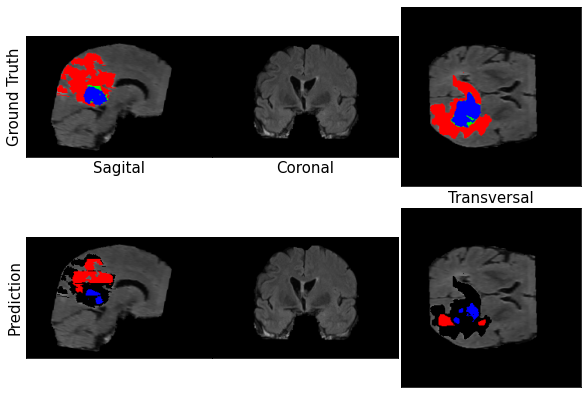

In [ ]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")
pred = predict_and_viz(image, label, model, .5, loc=(130, 130, 77))                

#### Check how well the predictions do

We can see some of the discrepancies between the model and the ground truth visually. 
- We can also use the functions we wrote previously to compute sensitivity and specificity for each class over the whole scan.
- First we need to format the label and prediction to match our functions expect.

In [ ]:
whole_scan_label = keras.utils.to_categorical(label, num_classes = 4)
whole_scan_pred = pred

# move axis to match shape expected in functions
whole_scan_label = np.moveaxis(whole_scan_label, 3 ,0)[1:4]
whole_scan_pred = np.moveaxis(whole_scan_pred, 3, 0)[1:4]

Now we can compute sensitivity and specificity for each class just like before.

In [ ]:
whole_scan_df = get_sens_spec_df(whole_scan_pred, whole_scan_label)

print(whole_scan_df)

              Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity  0.3787                   0          0.4446
Specificity  0.9996                   1               1
